# Imports

In [1]:
from collections import namedtuple

import os
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.width',1000)


from shared import *

# Constants

In [2]:
DATASET_INPUT = DATASETS_PATHS.originals
DATASET_OUTPUT = DATASETS_PATHS.processed

TRAIN_PERCENT = .66# .7
VAL_PERCENT = .2
TEST_PERCENT = .14# .1
RANDOM_STATE = None

# Data preprocessing

## Dataset creation (and adaptation)

In [3]:
dataset = pd.read_csv(DATASET_INPUT.info)
dataset.rename(columns={"SetId": "setid", "FName": "imgid", "URL": "path"}, inplace=True)
dataset.path = dataset.apply(lambda x: os.path.join(DATASET_INPUT.data, f'{x.UserRace}s', x.path), axis=1)
dataset.drop(columns=["UserRace", "Age","Name", 'imgid'], inplace=True)

print("> num elementos:", dataset.count(axis=1).size)
print("> num ids diferentes", len(dataset.setid.unique()))
print(dataset.setid.value_counts())
dataset.head()

> num elementos: 435
> num ids diferentes 29
setid
0001cc1e1e--61af8513667cba1b47349869    15
0001ca9b9a--61ab93399e265a148f85e5d0    15
0001ca9b9a--61af4a11ec7c4619a7c95ddf    15
0001ca9b9a--61adf4903e0f222c5a048507    15
0001ca9b9a--61ad582184c9021db9ea19df    15
0001ca9b9a--61ad4051889fb241713def3a    15
0001ca9b9a--61ad04a074501f072eccf903    15
0001ca9b9a--61acdab83e0f222c5afd75a2    15
0001ca9b9a--61acd3c5b402c12388930bcf    15
0001ca9b9a--61ac9cfdd211124f5daebd40    15
0001ca9b9a--61ac93aeed797b7414edf419    15
0001ca9b9a--61abcfbb45612c79df4dba1f    15
0001ca9b9a--61abceec4376670967375e12    15
0001ca9b9a--61ab9a5e686e3d72a4be5551    15
0001ca9b9a--61ab5c83d6d182382f227ccb    15
0001cc1e1e--61af86f374501f072edf6d2c    15
0001ca9b9a--61ab3a5fd6d182382f20a168    15
0001ca9b9a--61ab21f4277a1c323b746383    15
0001ca9b9a--61aa90111e37d6183d870ea5    15
0001cc1e1e--61af91e464610d607e3a329e    15
0001cc1e1e--61af8d4045612c79df65d153    15
0001cc1e1e--61af8d2aad9d9c12b4864776    15
000

,setid,path
0,0001cc1e1e--61af8513667cba1b47349869,data/dataset/Selfies ID Images dataset\Hispani...
1,0001cc1e1e--61af8513667cba1b47349869,data/dataset/Selfies ID Images dataset\Hispani...
2,0001cc1e1e--61af8513667cba1b47349869,data/dataset/Selfies ID Images dataset\Hispani...
3,0001cc1e1e--61af8513667cba1b47349869,data/dataset/Selfies ID Images dataset\Hispani...
4,0001cc1e1e--61af8513667cba1b47349869,data/dataset/Selfies ID Images dataset\Hispani...


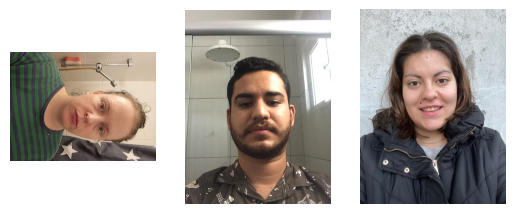

In [4]:
# look if we have images
plt.figure()
for i,img in enumerate(dataset.path.sample(3)):
	plt.subplot(1,3,i+1)
	plt.axis('off')
	plt.imshow(plt.imread(img))

## Data balancing

In [5]:
min_set_size = dataset.setid.value_counts().min()
print("> Cantidad de imagenes de la setid que menos tiene:", min_set_size)

> Cantidad de imagenes de la setid que menos tiene: 15


In [6]:
# Although is not necesary in this case, I want to create a code usable in other cases (maybe i change my dataset)
dataset = pd.DataFrame(dataset.groupby("setid")[dataset.columns].apply(lambda setid: setid.sample(min_set_size, random_state=RANDOM_STATE)).reset_index(drop=True))

print("> Cantidad de elementos:", dataset.count(axis=1).size, end='\n\n')
print(dataset.setid.value_counts())
dataset.head()

> Cantidad de elementos: 435

setid
0001ca9b9a--61aa90111e37d6183d870ea5    15
0001ca9b9a--61adf4903e0f222c5a048507    15
0001cc1e1e--61af8d4045612c79df65d153    15
0001cc1e1e--61af8d2aad9d9c12b4864776    15
0001cc1e1e--61af8bd7667cba1b473506bd    15
0001cc1e1e--61af8b9119bf98074e184806    15
0001cc1e1e--61af8aa9d46ff461a71462cc    15
0001cc1e1e--61af8a351735844b198f7ade    15
0001cc1e1e--61af89eea5a19325b68a2801    15
0001cc1e1e--61af892e1735844b198f7269    15
0001cc1e1e--61af86f374501f072edf6d2c    15
0001cc1e1e--61af8513667cba1b47349869    15
0001ca9b9a--61af51c056ee9447b653e097    15
0001ca9b9a--61af4a11ec7c4619a7c95ddf    15
0001ca9b9a--61ad582184c9021db9ea19df    15
0001ca9b9a--61ab21f4277a1c323b746383    15
0001ca9b9a--61ad4051889fb241713def3a    15
0001ca9b9a--61ad04a074501f072eccf903    15
0001ca9b9a--61acdab83e0f222c5afd75a2    15
0001ca9b9a--61acd3c5b402c12388930bcf    15
0001ca9b9a--61ac9cfdd211124f5daebd40    15
0001ca9b9a--61ac93aeed797b7414edf419    15
0001ca9b9a--61abcf

,setid,path
0,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
1,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
2,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
3,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
4,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...


## Save / load preprocessed database

### Save database

In [7]:
dataset.to_csv(DATASET_OUTPUT.info, index=False)

### Load database

In [8]:
dataset = pd.read_csv(DATASET_OUTPUT.info)
dataset.head()

,setid,path
0,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
1,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
2,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
3,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
4,0001ca9b9a--61aa90111e37d6183d870ea5,data/dataset/Selfies ID Images dataset\Caucasi...
